# Mining stock price prediction with LSTM Multivariable
---
## Autores:

Angel Jorge Salazar | Data Analytics @ Kobranzas SAC
* Github: https://github.com/ANGELJSS
* Linkedin https://www.linkedin.com/in/angel-jorge-salazar-7b3bb614b/

Heydy Mayumy Carrasco Huaccha | Data Analytics @ Contraloría General de la República del Perú
* Github: https://github.com/MayumyCH
* Linkedin https://www.linkedin.com/in/heydy-mayumy-carrasco-huaccha-3876bb137/

Jorge Sepúlveda Sepúlveda | Consultor DBA Oracle @ Datactiva
* Github: https://github.com/xbash
* Linkedin https://www.linkedin.com/in/xbash/

---

<img src="https://www.aboutespanol.com/thmb/tucVaDrXW_EDVJ586lE3e-tZYJM=/2309x1299/filters:fill(auto,1)/bolsadelvalores-5ae6450b04d1cf003c23246f.jpg" alt="descargar" border="0" height=280>

_En este proyecto se propone el análisis de la data registrada en la pagina Investing para los años del 2013 al 2021; se busca predecir el precio de las acciones para la Compañia de Minas Buenaventura al finalizar el dia; este logro conllevaría a que los inversionistas puedan elegir las acciones que le ofrescan mayor rendimiento de beneficios._

**Link de los data:**


*   [Data de la Compania de Minas Buenaventura](https://es.investing.com/equities/buenaventura-mining?cid=102138)

  Este conjunto de data se obtuvo de consultar la pagina  [investing](https://es.investing.com/equities/buenaventura-mining?cid=10213) para la Compañia de Minas Buenaventura en los años del 2013 al 2021.
  Esta data contiene 1939 registros diarios, cuyas columnas son: Fecha, últimoP(precio de cierre del día), Apertura(precio de apertura del día), Máximo(precio máximo del día), Mínimo(precio mínimo del día), Vol.(Volumen de transacción) y %var(porcentaje de variación del precio) todos estos correspondientes a las acciones de la empresa antes mencionada.



## Importación de librerias

In [ ]:
# Importación de librerías a utilizar 

import numpy as np
import tensorflow as tf
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import datetime as dt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler # Para escalar nuestros datos
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
%matplotlib inline

## Importar datos

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/MayumyCH/mining_stock_price_prediction_with_lstm/main/dataset/datos_mina_buenaventura.csv", decimal=",")
df.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,11.06.2021,10.81,10.80,10.92,10.79,"2,92K","0,09%"
1,10.06.2021,10.80,10.64,10.90,10.61,"76,43K","1,69%"
2,09.06.2021,10.62,10.96,10.96,10.61,"40,36K","-3,19%"
3,08.06.2021,10.97,11.09,11.12,10.90,"10,31K","-3,01%"
4,07.06.2021,11.31,11.45,12.11,11.30,"64,69K","-7,45%"


Realizando modificaciones a nuestros features: Fecha, Vol. y % Var.

In [ ]:
# VARIABLE : Vol. y % Var.
# Reemplazamos valores como la coma, la K, M y %
df['Vol.']=df['Vol.'].str.replace(',', "").str.replace('K', "0").str.replace('M', "0000").str.replace('-', "0").astype(str)
df['% var.']=df['% var.'].str.replace(',', ".").str.replace('%', "").astype(str)
#Luego convertimos  de string a float
df['Vol.']= df['Vol.'].astype(float)
df['% var.']= (df['% var.'].astype(float))/100

# VARIABLE : Fecha
# Convertir nuestra columna Fecha que esta como String a formato Fecha
df['Fecha'] = [fecha.replace('.', '-') for fecha in df['Fecha']]
df['Fecha'] = [datetime.strptime(fecha, '%d-%m-%Y').date() for fecha in df['Fecha']]
# Comprobando que los valores esten en formato fecha
print(type(df['Fecha'][0]))
df.head()

<class 'datetime.date'>


,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,2021-06-11,10.81,10.80,10.92,10.79,2920.0,0.0009
1,2021-06-10,10.80,10.64,10.90,10.61,76430.0,0.0169
2,2021-06-09,10.62,10.96,10.96,10.61,40360.0,-0.0319
3,2021-06-08,10.97,11.09,11.12,10.90,10310.0,-0.0301
4,2021-06-07,11.31,11.45,12.11,11.30,64690.0,-0.0745


Nuestra fechas  se encuentran en orden descendiente por ello procederemos a cambiar el orden de forma ascendente por coveniencia, para el desarrollo de nustro modelo LSTM.


In [ ]:
df= df.sort_values('Fecha')
df.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
1938,2013-06-13,17.94,17.50,17.95,17.50,4030.0,0.0310
1937,2013-06-14,17.20,17.20,17.20,17.20,280.0,-0.0412
1936,2013-06-17,17.31,17.31,17.31,17.31,100.0,0.0064
1935,2013-06-19,17.41,17.41,17.90,17.41,700.0,0.0058
1934,2013-06-20,16.80,17.20,17.20,16.72,1770.0,-0.0350


In [ ]:
df.shape
# Datos de la empresa minera
# 1939 registros de los valores de las acciones
# 7 features

(1939, 7)

**DESCRIPCIÓN DE LA DATA**

El dataset contiene 7 features:



VARIABLE | DESCRIPCIÓN | 
----- | ---- |
Fecha   | Fecha del registro de los valores de las acciones | 
Último  | Precio de cierre de las acciones del día‎  | 
Apertura  | Precio de apertura de las acciones del día‎  |
Máximo  | El precio más alto de las acciones del día‎  | 
Mínimo  | El precio más bajo de las acciones del día‎  | 
Vol.  | Monto de transacción del dia  | 
% var.  | Variación porcentual del precio actual respecto al precio de la transacción anterior inmediato  |

In [ ]:
df.info()
# No hay datos faltantes en nuestra data
# 1 feature "Fecha" de tipo object
# 6 features de tipo decimal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1939 entries, 1938 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Fecha     1939 non-null   object 
 1   Último    1939 non-null   float64
 2   Apertura  1939 non-null   float64
 3   Máximo    1939 non-null   float64
 4   Mínimo    1939 non-null   float64
 5   Vol.      1939 non-null   float64
 6   % var.    1939 non-null   float64
dtypes: float64(6), object(1)
memory usage: 121.2+ KB


In [ ]:
df.describe()

,Último,Apertura,Máximo,Mínimo,Vol.,% var.
count,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000
mean,12.072130,12.076060,12.204801,11.948334,27096.591026,0.000269
std,2.862575,2.857596,2.858970,2.861841,45296.270204,0.032110
min,3.400000,3.390000,3.500000,3.300000,0.000000,-0.230800
25%,10.700000,10.700000,10.860000,10.565000,4005.000000,-0.015700
50%,12.390000,12.380000,12.500000,12.250000,12340.000000,0.000000
75%,14.090000,14.105000,14.200000,14.000000,31425.000000,0.015400
max,17.940000,17.690000,17.950000,17.550000,643100.000000,0.210900


**VISUALIZACIÓN DE LOS DATOS**


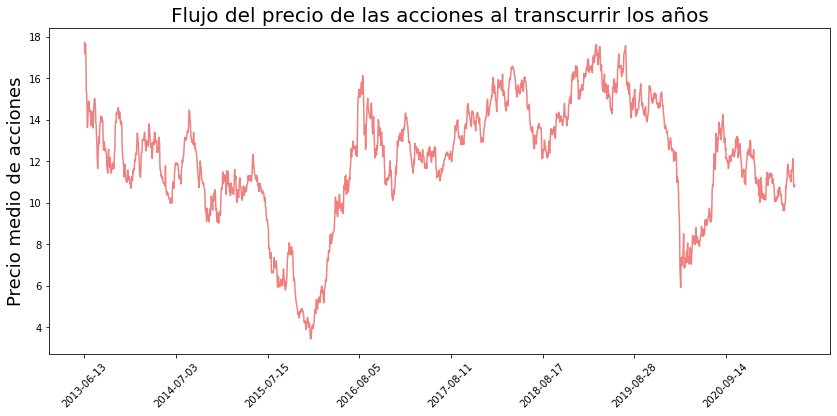

In [ ]:
plt.figure(figsize = (14,6)) # largo - ancho
plt.plot(range(df.shape[0]),(df['Mínimo']+df['Máximo'])/2.0, color ='#F08080')
plt.xticks(range(0,df.shape[0],250),df['Fecha'].loc[::250],rotation=45)
# plt.xlabel('Fecha',fontsize=18)
plt.ylabel('Precio medio de acciones',fontsize=18)
plt.title('Flujo del precio de las acciones al transcurrir los años',fontsize=20)
plt.show()

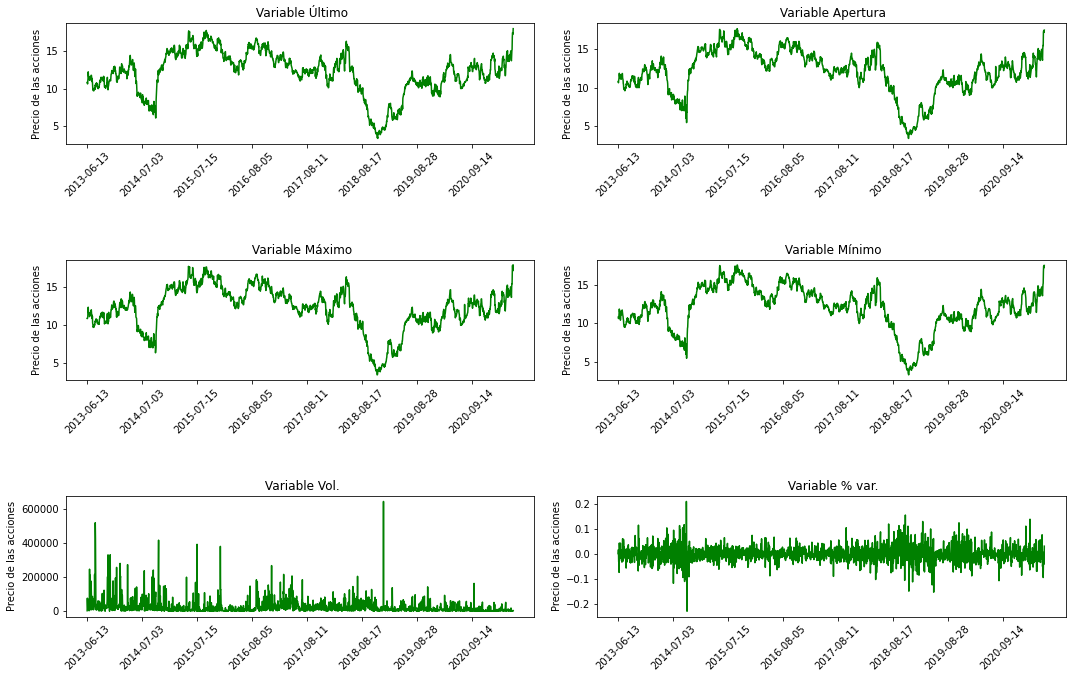

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
feature_list = ["Último", "Apertura", "Máximo", "Mínimo","Vol.","% var."]
for i, company in enumerate(feature_list, 1):
    plt.subplot(3, 2, i)
    plt.plot(df[company],color ='g')
    plt.ylabel('Precio de las acciones')
    plt.xticks(range(0,df.shape[0],250),df['Fecha'].loc[::250],rotation=45)
    plt.xlabel(None)
    plt.title(f" Variable {feature_list[i - 1]}")
plt.tight_layout()

## Preparacion de los datos

In [ ]:
# Seleccionar features (columnas) para participar en el entrenamiento y las predicciones
cols = list(df)[1:7]

# Extracion de dates - para poder apoyarnos con la visualizacion
datelist_train=df["Fecha"]
print('Conjunto de datos  (fila,columna) == {}'.format(df.shape))
print('Cantidad de fechas que se tiene == {}'.format(len(datelist_train)))
print('Features seleccionados: {}'.format(cols))

Conjunto de datos  (fila,columna) == (1939, 7)
Cantidad de fechas que se tiene == 1939
Features seleccionados: ['Último', 'Apertura', 'Máximo', 'Mínimo', 'Vol.', '% var.']


In [ ]:
dataset_train = df
dataset_train.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
1938,2013-06-13,17.94,17.50,17.95,17.50,4030.0,0.0310
1937,2013-06-14,17.20,17.20,17.20,17.20,280.0,-0.0412
1936,2013-06-17,17.31,17.31,17.31,17.31,100.0,0.0064
1935,2013-06-19,17.41,17.41,17.90,17.41,700.0,0.0058
1934,2013-06-20,16.80,17.20,17.20,16.72,1770.0,-0.0350


In [ ]:
dataset_train = df.copy()
dataset_train = dataset_train[cols].astype(str)

dataset_train.head()
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Usar múltiples features (predictores) 
training_set = dataset_train.to_numpy()

print('Forma del conjunto == {}.'.format(training_set.shape))
training_set

Forma del conjunto == (1939, 6).


array([[ 1.794e+01,  1.750e+01,  1.795e+01,  1.750e+01,  4.030e+03,
         3.100e-02],
       [ 1.720e+01,  1.720e+01,  1.720e+01,  1.720e+01,  2.800e+02,
        -4.120e-02],
       [ 1.731e+01,  1.731e+01,  1.731e+01,  1.731e+01,  1.000e+02,
         6.400e-03],
       ...,
       [ 1.062e+01,  1.096e+01,  1.096e+01,  1.061e+01,  4.036e+04,
        -3.190e-02],
       [ 1.080e+01,  1.064e+01,  1.090e+01,  1.061e+01,  7.643e+04,
         1.690e-02],
       [ 1.081e+01,  1.080e+01,  1.092e+01,  1.079e+01,  2.920e+03,
         9.000e-04]])

‎Normalizando los datos‎

In [ ]:
'''
Se procede a escalar los features de la data
'''
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[ 2.05038598],
       [ 1.79181079],
       [ 1.83024764],
       ...,
       [-0.50741187],
       [-0.4445152 ],
       [-0.44102094]])

In [ ]:
# Creando la estructura de la datos
X_train = []
y_train = []

n_future = 60   # Número de días que queremos predecir en el futuro
n_past = 90     # Número de días pasados que queremos usar para predecir el futuro 

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train dimension == {}.'.format(X_train.shape))
print('y_train dimension == {}.'.format(y_train.shape))

X_train dimension == (1790, 90, 5).
y_train dimension == (1790, 1).


## Creación del Modelo

In [ ]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [ ]:
# Creando nuestro modelo de red
model = Sequential()

# Añadiendo la 1ra capa de LSTM 
model.add(LSTM(units=64, return_sequences=True, 
               input_shape=(n_past, dataset_train.shape[1]-1)))

# Añadiendo la 2da capa de LSTM
model.add(LSTM(units=10, return_sequences=False))
#Es la fracción de apagar neuronar al 25% en las capas. 
model.add(Dropout(0.25))

# Capa de salida
model.add(Dense(units=1, activation='linear'))


In [ ]:
# Compilando la red neuronal 
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 90, 64)            17920     
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                3000      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 20,931
Trainable params: 20,931
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=38,
                    callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=32)

Epoch 1/38
45/45 [==============================] - 9s 118ms/step - loss: 0.7144 - accuracy: 0.0000e+00 - val_loss: 1.3341 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.33413, saving model to weights.h5
Epoch 2/38
45/45 [==============================] - 4s 79ms/step - loss: 0.5281 - accuracy: 0.0000e+00 - val_loss: 1.2478 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 1.33413 to 1.24778, saving model to weights.h5
Epoch 3/38
45/45 [==============================] - 3s 77ms/step - loss: 0.5230 - accuracy: 0.0000e+00 - val_loss: 1.0756 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from 1.24778 to 1.07563, saving model to weights.h5
Epoch 4/38
45/45 [==============================] - 3s 77ms/step - loss: 0.4146 - accuracy: 0.0000e+00 - val_loss: 1.2011 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 1.07563
Epoch 5/38
45/45 [==============================] - 3s 78ms/step - loss: 0.3524 - accuracy: 0.0000e+00 

In [ ]:
datelist_future = pd.date_range(datelist_train.values[-1], periods=n_future, freq='1d').tolist()

# Convierta Pandas Timestamp to Datetime object (para la transformación) -> FUTURO 
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

## Predicción basado en nuestro modelo

In [ ]:
# Realizar predicciones 
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:
# Invierta las predicciones a las medidas originales

#  Convertir <datetime.date> a <Timestamp>
def datetime_to_timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Último']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Último']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convertir <datetime.date> a <Timestamp> para PREDICITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Último
Fecha,
2014-06-18,12.109806
2014-06-19,11.968737
2014-06-20,11.937812


In [ ]:
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

Con 38 epochs

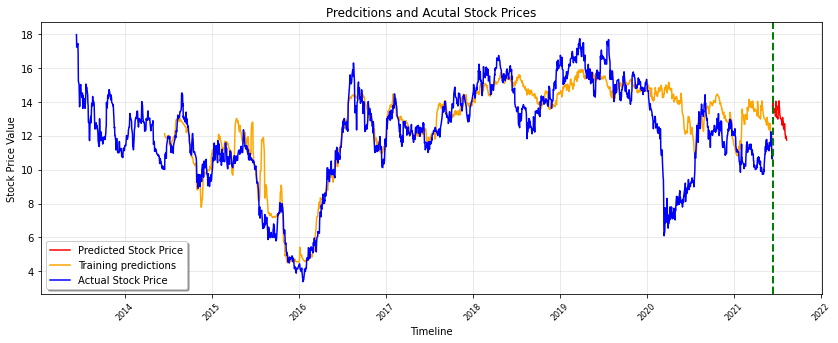

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

START_DATE_FOR_PLOTTING = '2013-06-13'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Último'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Último'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Último'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')
plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()